In [1]:
%pylab inline
import pandas as pd
from dateparser import parse
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
import itertools as it

Populating the interactive namespace from numpy and matplotlib


In [2]:
ex = pd.ExcelFile('WDImetadata.xlsx')
explainer = ex.parse('2010-2019 MetaData').set_index('Code').fillna('')
def explain(c, topic='Long definition'):
    global explainer
    return explainer.loc[c][topic]

In [3]:
def z_score(s):
    return (s-s.mean())/s.std()

In [4]:
df = pd.read_csv('cleaned.csv', parse_dates=['Custom_Time_Code'])
df = df[df['Country Code'] != 'USA']

df_z = pd.concat([z_score(df[col]) for col in tqdm(df.columns) if col not in ['Country Code', 'Custom_Time_Code']], axis=1)
df_z.columns = df.columns[2:]

df_no_outliers = df.where(df_z.abs() < 2).iloc[:,2:]
df_no_outliers = pd.concat([df['Country Code'], df['Custom_Time_Code'], df_no_outliers], axis=1)

100%|██████████| 940/940 [00:01<00:00, 566.48it/s]


In [12]:
def s_chg(s):
    s = s.values
    return s[-1]-s[0]

def df_chg(df):
    new = []
    for c in df.columns:
        new.append(s_chg(df[c]))
    new = pd.Series(new)
    new.index = ['DELTA_' + c for c in df.columns]
    return new

In [13]:
gini = 'SI.POV.GINI'
gdp  = 'NY.GDP.PCAP.CD'
ccode = 'Country Code'

In [18]:
chg = df_no_outliers[[ccode, gini, gdp]].groupby(ccode).apply(df_chg).dropna()

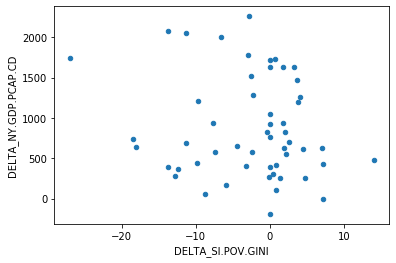

In [19]:
chg.plot.scatter('DELTA_'+gini, 'DELTA_'+gdp)

In [22]:
df_2010 = df[df['Custom_Time_Code'] > parse('Jan 1st 2009')]
data = df_2010.iloc[:, 2:]

data_z = pd.concat([z_score(data[col]) for col in tqdm(data.columns)], axis=1)
data_z.columns = data.columns

data_no_outliers = data.where(data_z.abs() < 2)
data_no_outliers = data_no_outliers.set_index(df_2010['Country Code'])

100%|██████████| 938/938 [00:01<00:00, 626.74it/s]


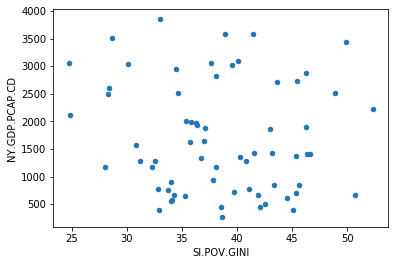

In [24]:
data_no_outliers.plot.scatter(gini, gdp)

In [25]:
corr_no_outliers = data_no_outliers.corr('pearson')

visited = set()
r_values = []
for i,j in tqdm(it.product(data.columns, data.columns)):
    i_prefix = i.split('.')[0]
    j_prefix = j.split('.')[0]
    if (i!=j) and (i_prefix != j_prefix) and ((j,i) not in visited):
        r = corr_no_outliers.loc[i, j]
        r_values.append((r, i, j))
        visited.add((i,j))
        
between_set_corr = pd.DataFrame.from_records(r_values)

between_set_corr.columns = ['r', 'i', 'j']

879844it [00:13, 62866.84it/s] 


In [30]:
g_corr = between_set_corr[between_set_corr.i==gini]

In [38]:
g_corr[(g_corr.r.abs() > .4)]

,r,i,j
201849,-0.494758,SI.POV.GINI,EN.ATM.HFCG.KT.CE
201850,-0.411828,SI.POV.GINI,SH.MED.BEDS.ZS
201923,0.413501,SI.POV.GINI,SL.TLF.ACTI.1524.NE.ZS
201930,0.415994,SI.POV.GINI,SL.TLF.CACT.ZS
202265,-0.493427,SI.POV.GINI,IS.RRS.TOTL.KM
202266,-0.418584,SI.POV.GINI,IS.RRS.GOOD.MT.K6
202278,0.423019,SI.POV.GINI,SE.PRM.REPT.FE.ZS
202279,0.403886,SI.POV.GINI,SE.PRM.REPT.MA.ZS
202280,0.421318,SI.POV.GINI,SE.PRM.REPT.ZS
202340,-0.464118,SI.POV.GINI,SP.POP.BRTH.MF


In [40]:
explain('EN.ATM.HFCG.KT.CE', topic='Indicator Name')

'HFC gas emissions (thousand metric tons of CO2 equivalent)'

In [41]:
hiv = 'SH.DYN.AIDS.FE.ZS'
hfc_emissions = 'EN.ATM.HFCG.KT.CE'

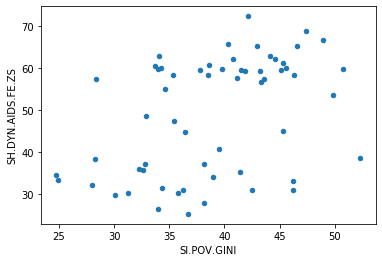

In [42]:
data_no_outliers.plot.scatter(gini, hiv)

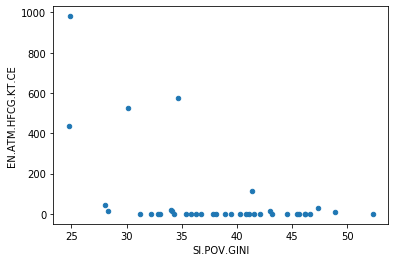

In [43]:
data_no_outliers.plot.scatter(gini, hfc_emissions)

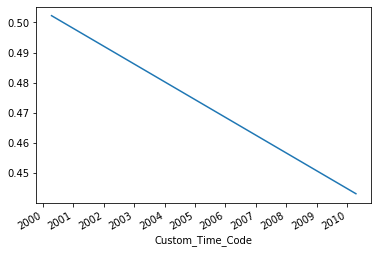

In [68]:
df_no_outliers.groupby('Custom_Time_Code')[gdp].mean().pct_change().plot()


Text(0.5, 1.0, 'Equality Growth: 1/gini % change')

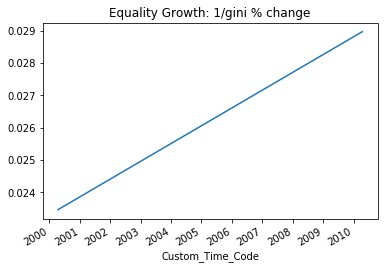

In [72]:
(1/df_no_outliers.groupby('Custom_Time_Code')[gini].mean()).pct_change().plot()
plt.title('Equality Growth: 1/gini % change')

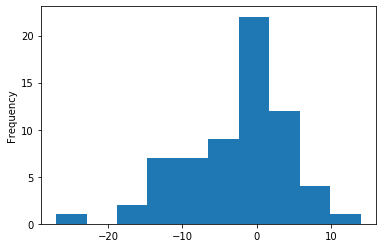

In [95]:
df_no_outliers.groupby('Country Code')[gini].apply(lambda x: s_chg(x)).sort_values().plot(kind='hist')